<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/05_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Run this if in COLAB
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip
    
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week5_explore/bayes.py
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week5_explore/action_rewards.npy
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week5_explore/all_states.npy

     | 30.5MB 6.3MB/s
  Created wheel for Theano: filename=Theano-1.0.4+unknown-cp36-none-any.whl size=2666479 sha256=a74ca8518dbb0c70c20aab572279ae23223840db5f5b1898d2b50589add66da3
  Stored in directory: /tmp/pip-ephem-wheel-cache-o6j79eck/wheels/33/73/96/0ed263c62a86e2485ea634e0d3ae8169d50fd66e3b252541db
Successfully built Theano
  Found existing installation: Theano 1.0.4+unknown
    Uninstalling Theano-1.0.4+unknown:
      Successfully uninstalled Theano-1.0.4+unknown
     \ 1.2MB 6.8MB/s
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-cp36-none-any.whl size=122750 sha256=90fbc2be022ceedbb37074705650b4a858d3139267003874ebf7bf4da8285d5a
  Stored in directory: /tmp/pip-ephem-wheel-cache-rq81oqok/wheels/ca/4a/00/87f1777b229481fe76562df7c0cfb993bc88ed0cc37e3f0ed4
Successfully built Lasagne
  Found existing installation: Lasagne 0.2.dev1
    Uninstalling Lasagne-0.2.dev1:
      Successfully uninstalled Lasagne-0.2.dev1


In [0]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas
import math
from matplotlib import pyplot as plt
%matplotlib inline

## Bernouli Bandit问题
* 实现几个简单的探索策略，解决这个问题。
* bandit有K个动作，每一个动作有 $0 \le \theta_k \le 1$的概率获得reward=1的奖励，这个概率分布对于agent是未知的，但是固定不变的。agent的优化目标最小化下面的等式：$$\rho = T\theta^* - \sum_{t=1}^T r_t$$T是选择次数,$\theta^* = \max_k\{\theta_k\}$
* 


In [0]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        if np.any(np.random.random() > self._probs[action]):
            return 0.0
        return 1.0

    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self._probs)

    def step(self):
        """ Used in nonstationary version
        """
        pass

    def reset(self):
        """ Used in nonstationary version
        """
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass

    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):
    def get_action(self):
        return np.random.randint(0, len(self._successes))

In [0]:
###

#### epsilon-greedy agent

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; $x_t \leftarrow argmax_{k}\hat\theta$ with probability $1 - \epsilon$ or random action with probability $\epsilon$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

Implement the algorithm above in the cell below:


In [0]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.01):
        self._epsilon = epsilon
        
    def best_action(self):
      #if self._total_pulls == 0:
        #print("actions={0}".format(len(self._successes)))
      max_p = -1
      best_action = -1
      for action, (a, b) in enumerate(zip(self._successes, self._failures)):
        if a + b == 0:
          best_action = action
          #print("break")
          break
        else:
          p = (1.0 * a) / (a + b)
        if max_p < p :
          max_p = p
          best_action = action
      return best_action
          

    def get_action(self):
        # YOUR CODE HERE
        # best_action
        best_action = self.best_action()
        is_choice_random_action = np.random.choice([True, False], p=[self._epsilon, 1-self._epsilon])
        random_action = np.random.choice(range(len(self._successes)))
        if is_choice_random_action:
          return random_action
        return best_action

    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

### UCB Agent
Epsilon-greedy strategy heve no preference for actions. It would be better to select among actions that are uncertain or have potential to be optimal. One can come up with idea of index for each action that represents otimality and uncertainty at the same time. One efficient way to do it is to use UCB1 algorithm:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; **end for** 
 $x_t \leftarrow argmax_{k}w$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

__Note:__ in practice, one can multiply $\sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$ by some tunable parameter to regulate agent's optimism and wilingness to abandon non-promising actions.

More versions and optimality analysis - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf

In [0]:
class UCBAgent(AbstractAgent):
    def get_action(self):
      max_p = -1
      best_action = -1
      for action, (a, b) in enumerate(zip(self._successes, self._failures)):
        if a + b == 0:
          best_action = action
          break
        else:
          t = self._total_pulls + 1
          p = (1.0 * a) / (a + b) + pow((2 * math.log(t,2)) / (a + b) , 0.5)
        if max_p < p :
          max_p = p
          best_action = action
      return best_action

   

### Thompson sampling

UCB1 algorithm does not take into account actual distribution of rewards. If we know the distribution - we can do much better by using Thompson sampling:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample $\hat\theta_k \sim beta(\alpha_k, \beta_k)$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; $x_t \leftarrow argmax_{k}\hat\theta$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**
 

More on Thompson Sampling:
https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

In [0]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
      theta_vals = []
      for action, (a, b) in enumerate(zip(self._successes, self._failures)):
        if a <=0 or b<=0:
          return action
        theta_vals.append(np.random.beta(a, b, size=1))
      best_action = np.argmax(theta_vals)
      return best_action


### 验证代码

In [0]:
def plot_regret(env, agents, n_steps=5000, n_trials=50):
    scores = {
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    }

    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  # change bandit's state if it is unstationary

    plt.figure(figsize=(17, 8))
    for agent in agents:
        plt.plot(np.cumsum(scores[agent.name]) / n_trials)

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

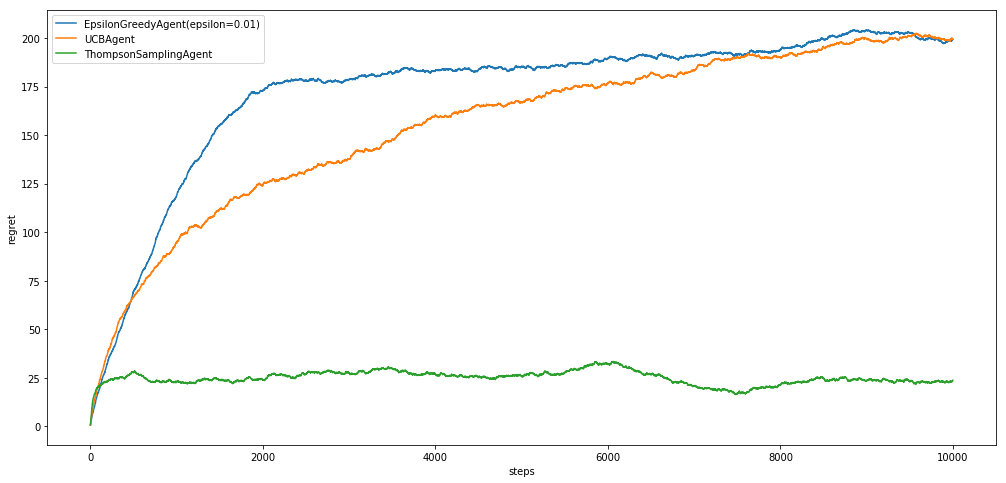

In [9]:
# Uncomment agents
agents = [
         EpsilonGreedyAgent(),
         UCBAgent(),
         ThompsonSamplingAgent()
]

plot_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)

## 实现Gittins index算法（+5分）

## nonstationary bernoulli bandit

bandit有k个动作，每个动作都有$\theta_k$的概率产生奖励r，并且概率随时间变化。


In [0]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, n_actions=5, gamma=0.01):
        """
        Idea from https://github.com/iosband/ts_tutorial
        """
        super().__init__(n_actions)

        self._gamma = gamma

        self._successes = None
        self._failures = None
        self._steps = 0

        self.reset()

    def reset(self):
        self._successes = np.zeros(self.action_count) + 1.0
        self._failures = np.zeros(self.action_count) + 1.0
        self._steps = 0

    def step(self):
        action = np.random.randint(self.action_count)
        reward = self.pull(action)
        self._step(action, reward)

    def _step(self, action, reward):
        self._successes = self._successes * (1 - self._gamma) + self._gamma
        self._failures = self._failures * (1 - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1.0 - reward

        self._probs = np.random.beta(self._successes, self._failures)

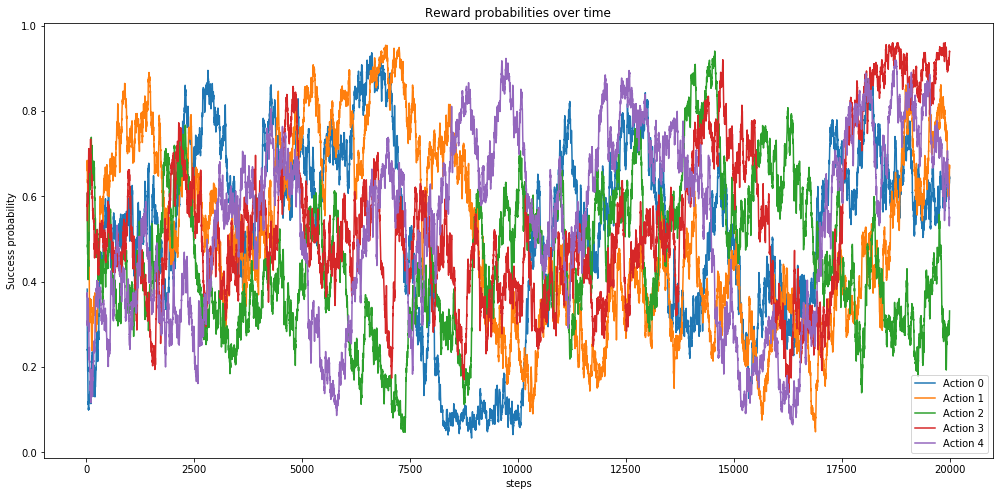

In [12]:
drifting_env = DriftingBandit(n_actions=5)

drifting_probs = []
for i in range(20000):
    drifting_env.step()
    drifting_probs.append(drifting_env._probs)

plt.figure(figsize=(17, 8))
plt.plot(pandas.DataFrame(drifting_probs).rolling(window=20).mean())

plt.xlabel("steps")
plt.ylabel("Success probability")
plt.title("Reward probabilities over time")
plt.legend(["Action {}".format(i) for i in range(drifting_env.action_count)])
plt.show()

任务：实现一个agent,比stationary agents有更好的效果

## contextual bandit

接着考虑更复杂的一种情况，即有多个状态的bandit,reward依赖于bandit的state

**现实状况类比：**
> 广告场景。广告平台有多个品牌和不同类型的用户，用户有年龄、性别、需求等不同特征。再展示某品牌的广告给用户时，我们喜欢用户点击的概率最大。

为了使用上面的策略，需要知道reward在不同action和state下的分布。

可以使用bayesian neural network解决这类问题。

<img src="https://github.com/450586509/reinforcement-learning-practice/blob/master/bnn.png?raw=1">
Picture from https://arxiv.org/pdf/1505.05424.pdf


More material:
  * A post on the matter - [url](http://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/)
  * Theano+PyMC3 for more serious stuff - [url](http://pymc-devs.github.io/pymc3/notebooks/bayesian_neural_network_advi.html)
  * Same stuff in tensorflow - [url](http://edwardlib.org/tutorials/bayesian-neural-network)
  
Let's load our dataset:

In [19]:
## 自己google搜索下载。原url可能失效

all_states = np.load("all_states.npy")
action_rewards = np.load("action_rewards.npy")

state_size = all_states.shape[1]
n_actions = action_rewards.shape[1]

print("State size: %i, actions: %i" % (state_size, n_actions))

State size: 60, actions: 10


### bayes.py中的内容

In [0]:
"""
A single-file module that makes your lasagne network into a bayesian neural net.
Originally created by github.com/ferrine , rewritten by github.com/justheuristic for simplicity
See example in the notebook
"""

import numpy as np

from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

import lasagne
from lasagne import init
from lasagne.random import get_rng

from functools import wraps

__all__ = ['NormalApproximation', 'get_var_cost', 'bbpwrap']


class NormalApproximation(object):
    def __init__(self, mu=0, std=np.exp(-3), seed=None):
        """
        Approximation that samples network weights from factorized normal distribution.
        :param mu: prior mean for gaussian weights
        :param std: prior std for gaussian weights
        :param seed: random seed
        """
        self.prior_mu = mu
        self.prior_std = std
        self.srng = RandomStreams(seed or get_rng().randint(1, 2147462579))

    def log_normal(self, x, mean, std, eps=0.0):
        """computes log-proba of normal distribution"""
        std += eps
        return - 0.5 * np.log(2 * np.pi) - T.log(T.abs_(std)) - \
            (x - mean) ** 2 / (2 * std ** 2)

    def log_prior(self, weights):
        """
        Logarithm of prior probabilities for weights:
        log P(weights) aka log P(theta)
        """
        return self.log_normal(weights, self.prior_mu, self.prior_std)

    def log_posterior_approx(self, weights, mean, rho):
        """
        Logarithm of ELBO on posterior probabilities:
        log q(weights|learned mu and rho) aka log q(theta|x)
        """
        std = T.log1p(T.exp(rho))  # rho to std
        return self.log_normal(weights, mean, std)

    def __call__(self, layer, spec, shape, name=None, **tags):
        # case when user uses default init specs
        assert tags.get(
            'variational', False), "Please declare param as variational to avoid confusion"

        if not isinstance(spec, dict):
            initial_rho = np.log(np.expm1(self.prior_std))  # std to rho
            assert np.isfinite(initial_rho), "too small std to initialize correctly. Please pass explicit"\
                " initializer (dict with {'mu':mu_init, 'rho':rho_init})."
            spec = {'mu': spec, 'rho': init.Constant(initial_rho)}

        mu_spec, rho_spec = spec['mu'], spec['rho']

        rho = layer.add_param(
            rho_spec, shape, name=(
                name or 'unk') + '.rho', **tags)
        mean = layer.add_param(
            mu_spec, shape, name=(
                name or 'unk') + '.mu', **tags)

        # Reparameterization trick
        e = self.srng.normal(shape, std=1)
        W = mean + T.log1p(T.exp(rho)) * e

        # KL divergence KL(q,p) = E_(w~q(w|x)) [log q(w|x) - log P(w)] aka
        # variational cost
        q_p = T.sum(
            self.log_posterior_approx(W, mean, rho) -
            self.log_prior(W)
        )

        # accumulate variational cost
        layer._bbwrap_var_cost += q_p
        return W


def get_var_cost(layer_or_layers, treat_as_input=None):
    """
    Returns total variational cost aka KL(q(theta|x)||p(theta)) for all layers in the network
    :param layer_or_layers: top layer(s) of your network, just like with lasagne.layers.get_output
    :param treat_as_input: don't accumulate over layers below these layers. See same param for lasagne.layers.get_all_layers
    Alternatively, one can manually get weights for one layer via layer.get_var_cost()
    """
    cost = 0
    for layer in lasagne.layers.get_all_layers(
            layer_or_layers, treat_as_input):
        if hasattr(layer, 'get_var_cost'):
            # if layer is bayesian or pretends so
            cost += layer.get_var_cost()
    return cost


def bbpwrap(approximation=NormalApproximation()):
    """
    A decorator that makes arbitrary lasagne layer into a bayesian network layer:
    BayesDenseLayer = bbwrap()(DenseLayer)
    or more verbosely,
    @bbpwrap(NormalApproximation(pstd=0.01))
    BayesDenseLayer(DenseLayer):
        pass
    """

    def decorator(cls):
        def add_param_wrap(add_param):
            @wraps(add_param)
            def wrapped(self, spec, shape, name=None, **tags):
                # we should take care about some user specification
                # to avoid bbp hook just set tags['variational'] = True
                if not tags.get('trainable', True) or \
                        tags.get('variational', False):
                    return add_param(self, spec, shape, name, **tags)
                else:
                    # we declare that params we add next
                    # are the ones we need to fit the distribution
                    # they don't need to be regularized, strictly
                    tags['variational'] = True
                    tags['regularizable'] = False
                    param = self.approximation(self, spec, shape, name, **tags)
                    return param
            return wrapped

        def get_var_cost(self):
            """
            Returns total variational cost aka KL(q(theta|x)||p(theta)) for this layer.
            Alternatively, use function get_var_cost(layer) to get total cost for all layers below this one.
            """
            return self._bbwrap_var_cost

        cls.approximation = approximation
        cls._bbwrap_var_cost = 0
        cls.add_param = add_param_wrap(cls.add_param)
        cls.get_var_cost = get_var_cost
        return cls

    return decorator

In [0]:
import theano
import theano.tensor as T
import lasagne
from lasagne import init
from lasagne.layers import *

as_bayesian = bbpwrap(NormalApproximation(std=0.1))
BayesDenseLayer = as_bayesian(DenseLayer)

### 构建一个bayesian neural network

实现一个epsilon-greedy BNN agent

In [24]:
class BNNAgent:
    """a bandit with bayesian neural net"""

    def __init__(self, state_size, n_actions):
        input_states = T.matrix("states")
        target_actions = T.ivector("actions taken")
        target_rewards = T.vector("rewards")

        self.total_samples_seen = theano.shared(
            np.int32(0), "number of training samples seen so far")
        batch_size = target_actions.shape[0]  # por que?

        # Network
        inp = InputLayer((None, state_size), name='input')
        # YOUR NETWORK HERE
        out = <Your network >

        # Prediction
        prediction_all_actions = get_output(out, inputs=input_states)
        self.predict_sample_rewards = theano.function(
            [input_states], prediction_all_actions)

        # Training

        # select prediction for target action
        prediction_target_actions = prediction_all_actions[T.arange(
            batch_size), target_actions]

        # loss = negative log-likelihood (mse) + KL
        negative_llh = T.sum((prediction_target_actions - target_rewards)**2)

        kl = bayes.get_var_cost(out) / (self.total_samples_seen+batch_size)

        loss = (negative_llh + kl)/batch_size

        self.weights = get_all_params(out, trainable=True)
        self.out = out

        # gradient descent
        updates = lasagne.updates.adam(loss, self.weights)
        # update counts
        updates[self.total_samples_seen] = self.total_samples_seen + \
            batch_size.astype('int32')

        self.train_step = theano.function([input_states, target_actions, target_rewards],
                                          [negative_llh, kl],
                                          updates=updates,
                                          allow_input_downcast=True)

    def sample_prediction(self, states, n_samples=1):
        """Samples n_samples predictions for rewards,

        :returns: tensor [n_samples, state_i, action_i]
        """
        assert states.ndim == 2, "states must be 2-dimensional"

        return np.stack([self.predict_sample_rewards(states) for _ in range(n_samples)])

    epsilon = 0.25

    def get_action(self, states):
        """
        Picks action by 
        - with p=1-epsilon, taking argmax of average rewards
        - with p=epsilon, taking random action
        This is exactly e-greedy policy.
        """

        reward_samples = self.sample_prediction(states, n_samples=100)
        # ^-- samples for rewards, shape = [n_samples,n_states,n_actions]

        best_actions = reward_samples.mean(axis=0).argmax(axis=-1)
        # ^-- we take mean over samples to compute expectation, then pick best action with argmax

        # YOUR CODE HERE
        chosen_actions = <-- implement epsilon-greedy strategy - ->

        return chosen_actions

    def train(self, states, actions, rewards, n_iters=10):
        """
        trains to predict rewards for chosen actions in given states
        """
        loss_sum = kl_sum = 0
        for _ in range(n_iters):
            loss, kl = self.train_step(states, actions, rewards)
            loss_sum += loss
            kl_sum += kl

        return loss_sum / n_iters, kl_sum / n_iters

    @property
    def name(self):
        return self.__class__.__name__

SyntaxError: ignored

### 训练代理

In [0]:
N_ITERS = 100

def get_new_samples(states, action_rewards, batch_size=10):
    """samples random minibatch, emulating new users"""
    batch_ix = np.random.randint(0, len(states), batch_size)
    return states[batch_ix], action_rewards[batch_ix]

from IPython.display import clear_output

from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

def train_contextual_agent(agent, batch_size=10, n_iters=100):
    rewards_history = []

    for i in range(n_iters):
        b_states, b_action_rewards = get_new_samples(
            all_states, action_rewards, batch_size)
        b_actions = agent.get_action(b_states)
        b_rewards = b_action_rewards[
            np.arange(batch_size), b_actions
        ]

        mse, kl = agent.train(b_states, b_actions, b_rewards, n_iters=100)

        rewards_history.append(b_rewards.mean())

        if i % 10 == 0:
            clear_output(True)
            print("iteration #%i\tmean reward=%.3f\tmse=%.3f\tkl=%.3f" %
                  (i, np.mean(rewards_history[-10:]), mse, kl))
            plt.plot(rewards_history)
            plt.plot(moving_average(np.array(rewards_history), alpha=0.1))
            plt.title("Reward per epesode")
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.show()

            samples = agent.sample_prediction(
                b_states[:1], n_samples=100).T[:, 0, :]
            for i in range(len(samples)):
                plt.hist(samples[i], alpha=0.25, label=str(i))
                plt.legend(loc='best')
            print('Q(s,a) std:', ';'.join(
                list(map('{:.3f}'.format, np.std(samples, axis=1)))))
            print('correct', b_action_rewards[0].argmax())
            plt.title("p(Q(s, a))")
            plt.show()

    return moving_average(np.array(rewards_history), alpha=0.1)

In [26]:
bnn_agent = BNNAgent(state_size=state_size, n_actions=n_actions)
greedy_agent_rewards = train_contextual_agent(
    bnn_agent, batch_size=10, n_iters=N_ITERS)

NameError: ignored

## 更好的探索

使用第一部分的策略，在contextual setting中获得更高的reward